In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from spellchecker import SpellChecker

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import Word, TextBlob
pd.set_option('display.max_colwidth', None)
spell = SpellChecker()
from PIL import Image
import os

In [3]:
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../../../1. Explorative Analysis & Preprocessing/nasiba/'))
os.chdir(src_path) 
#current_dir
src_path

'c:\\Users\\Nasiba\\Documents\\Repos_Clones\\WebScience24\\src\\1. Explorative Analysis & Preprocessing\\nasiba'

In [4]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/train.csv'))
df_origin = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
filepath_name = os.path.abspath(os.path.join(src_path, 'data/train_cleaned.csv'))
df_cleaned_origin = pd.read_csv(filepath_name, encoding='utf-8')

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/test.csv'))
df_origin_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)
filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/test_cleaned.csv'))
df_cleaned_test = pd.read_csv(filepath_name_test, encoding='utf-8', index_col=0)

#### Datenumfang

In [5]:
df_cleaned = df_cleaned_origin.copy()

In [6]:
print("Anzahl Datensätze der unbereinigten Traindaten")
print(df_origin.tweet.count())
print("Anzahl Datensätze der bereinigten Traindaten")
print(df_cleaned.tweet.count())
print("Anzahl der entfernten Datensätze während Cleaning")
print(df_cleaned.tweet.count() - df_origin.tweet.count())
print("Anteil der entfernten Datensätze während Cleaning")
print((df_cleaned.tweet.count() / df_origin.tweet.count() - 1) * 100)

Anzahl Datensätze der unbereinigten Traindaten
31962
Anzahl Datensätze der bereinigten Traindaten
27611
Anzahl der entfernten Datensätze während Cleaning
-4351
Anteil der entfernten Datensätze während Cleaning
-13.613040485576622


In [7]:
print(df_origin[df_origin.label == 1].count())
print(df_cleaned[df_cleaned.label == 1].count())
print(df_cleaned[df_cleaned.label == 1].count() - df_origin[df_origin.label == 1].count())
print((df_cleaned[df_cleaned.label == 1].count() / df_origin[df_origin.label == 1].count() - 1) * 100)

label    2242
tweet    2242
dtype: int64
id               1805
label            1805
tweet            1805
tweet_cleaned    1805
user_handle      1805
hashtags         1805
emojis             92
dtype: int64
emojis             NaN
hashtags           NaN
id                 NaN
label           -437.0
tweet           -437.0
tweet_cleaned      NaN
user_handle        NaN
dtype: float64
emojis                 NaN
hashtags               NaN
id                     NaN
label           -19.491525
tweet           -19.491525
tweet_cleaned          NaN
user_handle            NaN
dtype: float64


#### Label Verteilung bereinigte vs. unbereinigte Datensätze

In [8]:
# Klassenverteilung in den ursprünglichen Trainingsdaten
train_label_counts = df_origin['label'].value_counts()
print("Klassenverteilung in den ursprünglichen Trainingsdaten:")
print(train_label_counts)

# Klassenverteilung in den bereinigten Trainingsdaten
train_cleaned_label_counts = df_cleaned['label'].value_counts()
print("\nKlassenverteilung in den bereinigten Trainingsdaten:")
print(train_cleaned_label_counts)


Klassenverteilung in den ursprünglichen Trainingsdaten:
label
0    29720
1     2242
Name: count, dtype: int64

Klassenverteilung in den bereinigten Trainingsdaten:
label
0    25806
1     1805
Name: count, dtype: int64


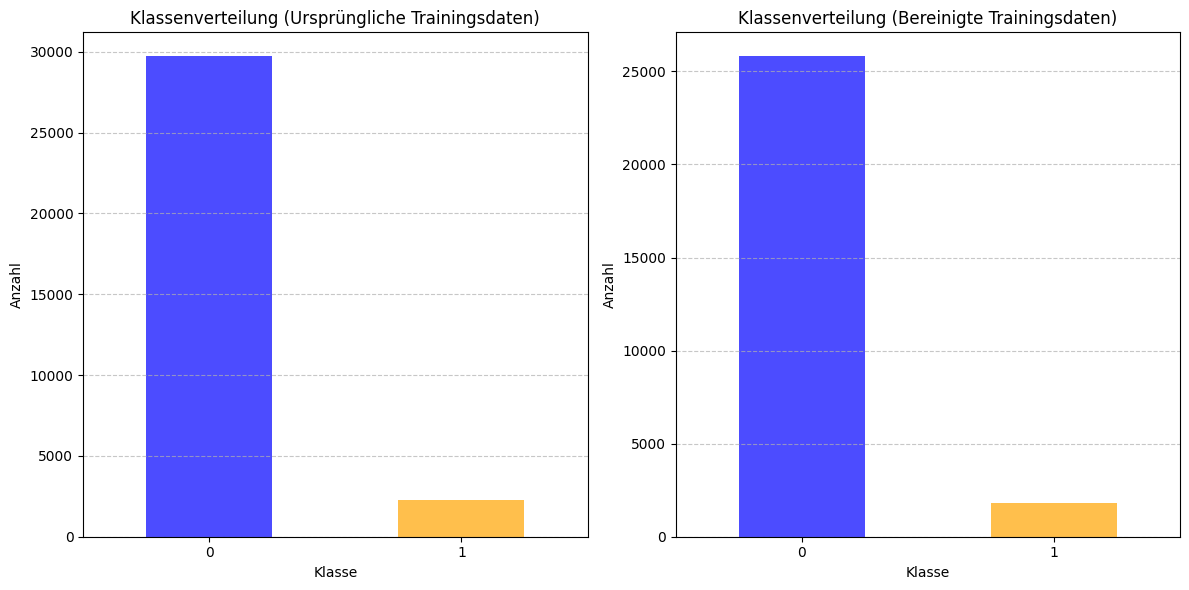

In [9]:
# Visualisierung der Klassenverteilung
plt.figure(figsize=(12, 6))

# Originale Daten
plt.subplot(1, 2, 1)
train_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Klassenverteilung (Ursprüngliche Trainingsdaten)')
plt.xlabel('Klasse')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bereinigte Daten
plt.subplot(1, 2, 2)
train_cleaned_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Klassenverteilung (Bereinigte Trainingsdaten)')
plt.xlabel('Klasse')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Statistiken der Train Daten vs. Test Daten

In [10]:
# Berechnung der Länge der Tweets
train_data_len = df_origin['tweet'].str.len()
test_data_len = df_origin_test['tweet'].str.len()

train_cleaned_data_len = df_cleaned['tweet_cleaned'].str.len()
test_cleaned_data_len = df_cleaned_test['tweet_cleaned'].str.len()

# Statistiken für Trainingsdaten
print("Statistiken zur Länge der Trainingsdaten:")
print(f"Durchschnittliche Länge: {train_data_len.mean():.2f}")
print(f"Median der Länge: {train_data_len.median():.2f}")
print(f"Minimale Länge: {train_data_len.min()}")
print(f"Maximale Länge: {train_data_len.max()}")
print(f"Standardabweichung: {train_data_len.std():.2f}\n")

# Statistiken für Testdaten
print("Statistiken zur Länge der Testdaten:")
print(f"Durchschnittliche Länge: {test_data_len.mean():.2f}")
print(f"Median der Länge: {test_data_len.median():.2f}")
print(f"Minimale Länge: {test_data_len.min()}")
print(f"Maximale Länge: {test_data_len.max()}")
print(f"Standardabweichung: {test_data_len.std():.2f} \n")

# Statistiken für bereinigte Trainingsdaten
print("Statistiken zur Länge der bereinigten Trainingsdaten:")
print(f"Durchschnittliche Länge: {train_cleaned_data_len.mean():.2f}")
print(f"Median der Länge: {train_cleaned_data_len.median():.2f}")
print(f"Minimale Länge: {train_cleaned_data_len.min()}")
print(f"Maximale Länge: {train_cleaned_data_len.max()}")
print(f"Standardabweichung: {train_cleaned_data_len.std():.2f}\n")

# Statistiken für bereinigte Testdaten
print("Statistiken zur Länge der bereinigten Testdaten:")
print(f"Durchschnittliche Länge: {test_cleaned_data_len.mean():.2f}")
print(f"Median der Länge: {test_cleaned_data_len.median():.2f}")
print(f"Minimale Länge: {test_cleaned_data_len.min()}")
print(f"Maximale Länge: {test_cleaned_data_len.max()}")
print(f"Standardabweichung: {test_cleaned_data_len.std():.2f}\n")


Statistiken zur Länge der Trainingsdaten:
Durchschnittliche Länge: 84.74
Median der Länge: 88.00
Minimale Länge: 11
Maximale Länge: 274
Standardabweichung: 29.46

Statistiken zur Länge der Testdaten:
Durchschnittliche Länge: 84.55
Median der Länge: 88.00
Minimale Länge: 11
Maximale Länge: 292
Standardabweichung: 29.61 

Statistiken zur Länge der bereinigten Trainingsdaten:
Durchschnittliche Länge: 43.85
Median der Länge: 42.00
Minimale Länge: 1.0
Maximale Länge: 515.0
Standardabweichung: 23.73

Statistiken zur Länge der bereinigten Testdaten:
Durchschnittliche Länge: 41.26
Median der Länge: 39.00
Minimale Länge: 1.0
Maximale Länge: 532.0
Standardabweichung: 23.07



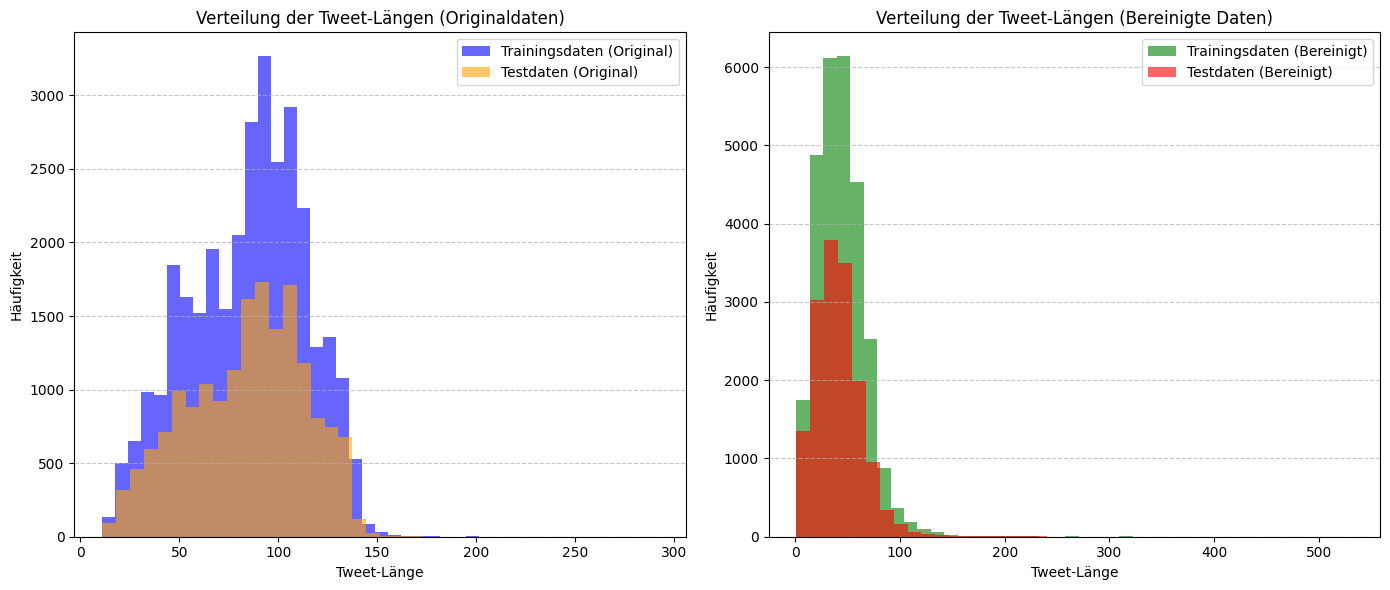

In [11]:
# Erstellung der Subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Originaldaten
plt.subplot(1, 2, 1)
plt.hist(train_data_len, bins=40, alpha=0.6, label='Trainingsdaten (Original)', color='blue')
plt.hist(test_data_len, bins=40, alpha=0.6, label='Testdaten (Original)', color='orange')
plt.title('Verteilung der Tweet-Längen (Originaldaten)')
plt.xlabel('Tweet-Länge')
plt.ylabel('Häufigkeit')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Bereinigte Daten
plt.subplot(1, 2, 2)
plt.hist(train_cleaned_data_len, bins=40, alpha=0.6, label='Trainingsdaten (Bereinigt)', color='green')
plt.hist(test_cleaned_data_len, bins=40, alpha=0.6, label='Testdaten (Bereinigt)', color='red')
plt.title('Verteilung der Tweet-Längen (Bereinigte Daten)')
plt.xlabel('Tweet-Länge')
plt.ylabel('Häufigkeit')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()


#### Analyse der Wörter in Tweets

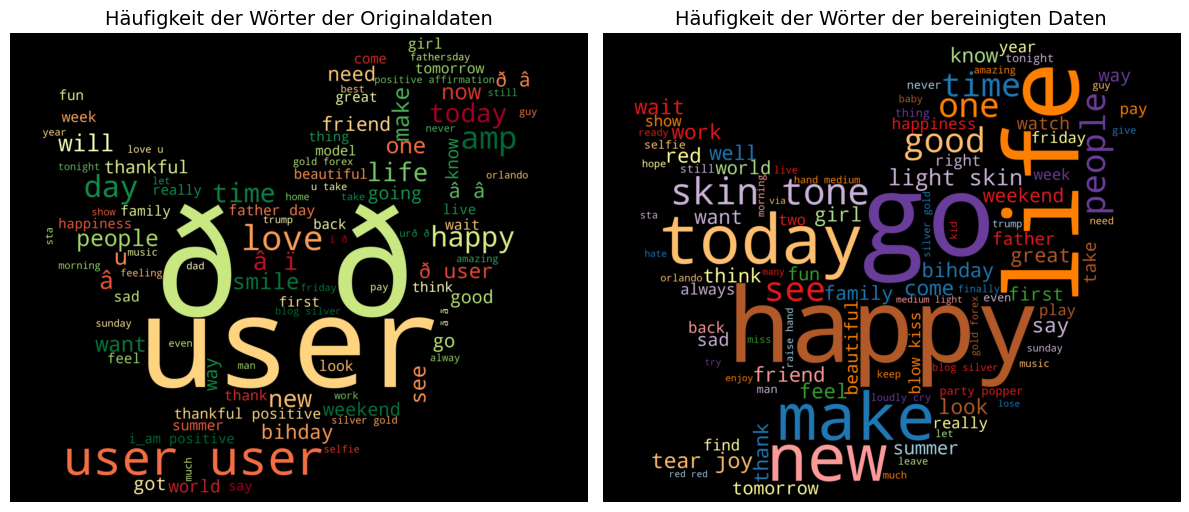

In [12]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_mask = np.array(Image.open("twitter.png"))

df_origin['tweet'] = df_origin['tweet'].apply(lambda x: x if isinstance(x, str) else '')
#origin_text = " ".join(tweet for tweet in df_origin['tweet'])

# Verarbeitung der Daten aus df_cleaned
df_cleaned['tweet_cleaned'] = df_cleaned['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')
#cleaned_text = " ".join(tweet for tweet in df_cleaned['tweet_cleaned'])

dataset_1_text = " ".join(df_origin["tweet"].tolist())  
dataset_2_text = " ".join(df_cleaned["tweet_cleaned"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Wörter der Originaldaten", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Wörter der bereinigten Daten", fontsize=14)  


plt.tight_layout()
plt.show()


#### Analyse der Wörter in Hate Speech Tweets

C:\Users\Nasiba\AppData\Local\Temp\ipykernel_10712\563957184.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_10712\563957184.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')


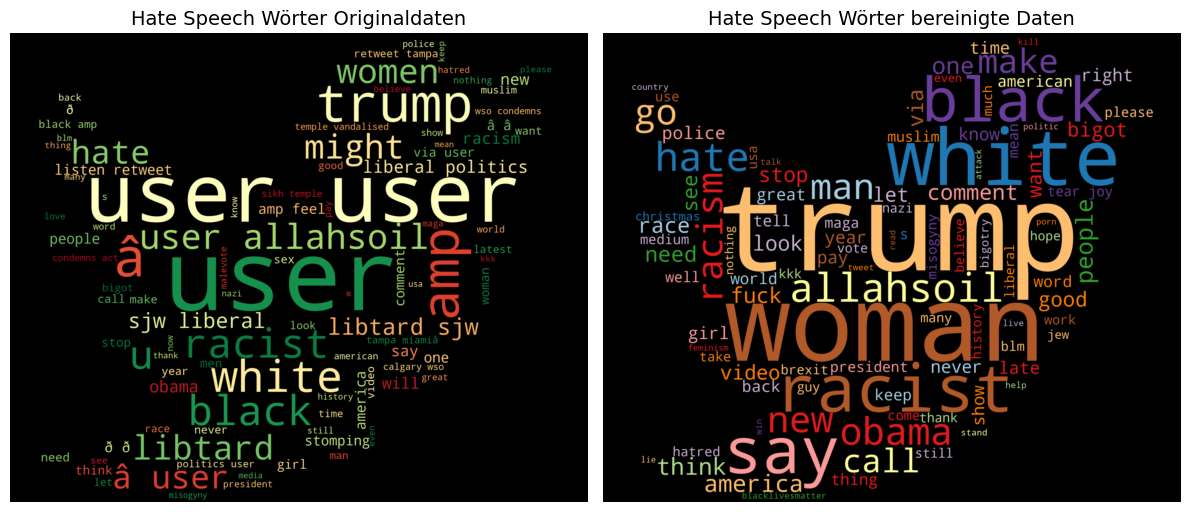

In [13]:
wordcloud_mask = np.array(Image.open("twitter.png"))

df_origin_label_1= df_origin[df_origin['label']==1]
df_cleaned_label_1= df_cleaned[df_cleaned['label']==1]


df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')

df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_origin_label_1["tweet"].tolist())  
dataset_2_text = " ".join(df_cleaned_label_1["tweet_cleaned"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter Originaldaten", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter bereinigte Daten", fontsize=14)  


plt.tight_layout()
plt.show()


#### Hashtag Analyse

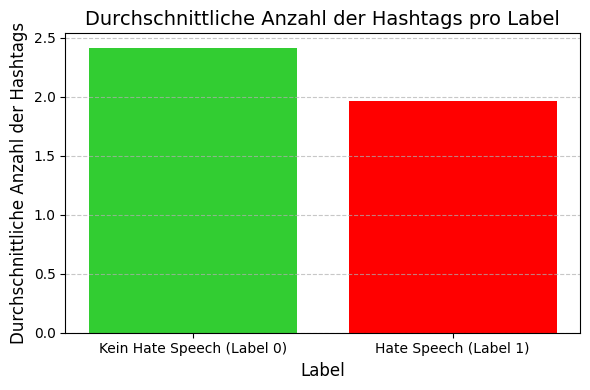

Durchschnittliche Anzahl der Hashtags in 'Kein Hate Speech' Tweets: 2.42
Durchschnittliche Anzahl der Hashtags in 'Hate Speech' Tweets: 1.96


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Gruppieren der Daten basierend auf dem Label und Berechnung der durchschnittlichen Anzahl der Hashtags

df_cleaned_new = df_cleaned.copy()
df_cleaned_new['num_hashtags'] = df_cleaned_new['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') else 0)

avg_hashtags = df_cleaned_new.groupby('label')['num_hashtags'].mean()

# Erstellen eines Barplots
plt.figure(figsize=(6, 4))
plt.bar(['Kein Hate Speech (Label 0)', 'Hate Speech (Label 1)'], avg_hashtags, color=['limegreen', 'red'])
plt.title('Durchschnittliche Anzahl der Hashtags pro Label', fontsize=14)
plt.ylabel('Durchschnittliche Anzahl der Hashtags', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anzeige des Ergebnisses
plt.tight_layout()
plt.show()

# Ausgabe der genauen Werte zur Unterstützung der Analyse
print(f"Durchschnittliche Anzahl der Hashtags in 'Kein Hate Speech' Tweets: {avg_hashtags[0]:.2f}")
print(f"Durchschnittliche Anzahl der Hashtags in 'Hate Speech' Tweets: {avg_hashtags[1]:.2f}")


C:\Users\Nasiba\AppData\Local\Temp\ipykernel_14292\3782159774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_0['hashtags'] = df_cleaned_label_0['hashtags'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_14292\3782159774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['hashtags'] = df_cleaned_label_1['hashtags'].apply(lambda x: x if isinstance(x, str) else '')


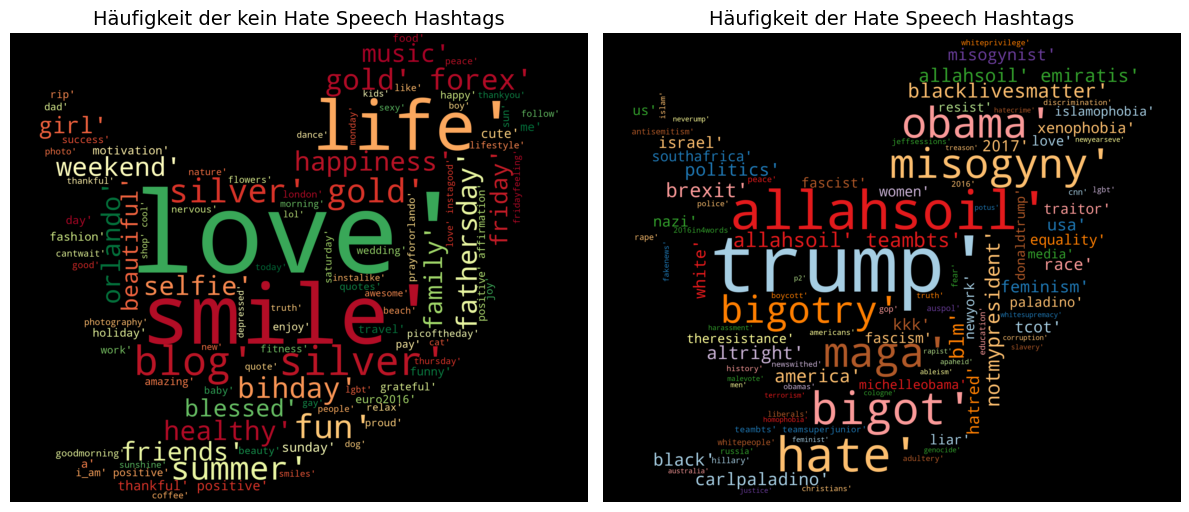

In [16]:
wordcloud_mask = np.array(Image.open("twitter.png"))

df_cleaned_label_0= df_cleaned[df_cleaned['label']==0]
df_cleaned_label_1= df_cleaned[df_cleaned['label']==1]


df_cleaned_label_0['hashtags'] = df_cleaned_label_0['hashtags'].apply(lambda x: x if isinstance(x, str) else '')

df_cleaned_label_1['hashtags'] = df_cleaned_label_1['hashtags'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_cleaned_label_0["hashtags"].tolist())  
dataset_2_text = " ".join(df_cleaned_label_1["hashtags"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der kein Hate Speech Hashtags", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Hate Speech Hashtags", fontsize=14)  


plt.tight_layout()
plt.show()


### Anzahl von Mentions und Hashtags pro Tweet

In [17]:

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_new['num_hashtags'] = df_cleaned_new['tweet'].apply(lambda x: x.count('#'))

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_new['num_hashtags'] = df_cleaned_new['tweet'].apply(lambda x: x.count('#'))

mentions_stats = {
    "Mean Mentions": df_cleaned_new['num_mentions'].mean(),
    "Median Mentions": df_cleaned_new['num_mentions'].median(),
    "Max Mentions": df_cleaned_new['num_mentions'].max(),
    "Min Mentions": df_cleaned_new['num_mentions'].min(),
    "Total Mentions": df_cleaned_new['num_mentions'].sum()
}

hashtags_stats = {
    "Mean Hashtags": df_cleaned_new['num_hashtags'].mean(),
    "Median Hashtags": df_cleaned_new['num_hashtags'].median(),
    "Max Hashtags": df_cleaned_new['num_hashtags'].max(),
    "Min Hashtags": df_cleaned_new['num_hashtags'].min(),
    "Total Hashtags": df_cleaned_new['num_hashtags'].sum()
}

print("Statistics for Mentions (@):")
for key, value in mentions_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

print("\nStatistics for Hashtags (#):")
for key, value in hashtags_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")


Statistics for Mentions (@):
Mean Mentions: 0.59
Median Mentions: 0.00
Max Mentions: 10
Min Mentions: 0
Total Mentions: 16248

Statistics for Hashtags (#):
Mean Hashtags: 2.40
Median Hashtags: 2.00
Max Hashtags: 20
Min Hashtags: 0
Total Hashtags: 66356


C:\Users\Nasiba\AppData\Local\Temp\ipykernel_14292\322232222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['num_mentions'] = df_cleaned_label_1['tweet'].apply(lambda x: x.count('@'))


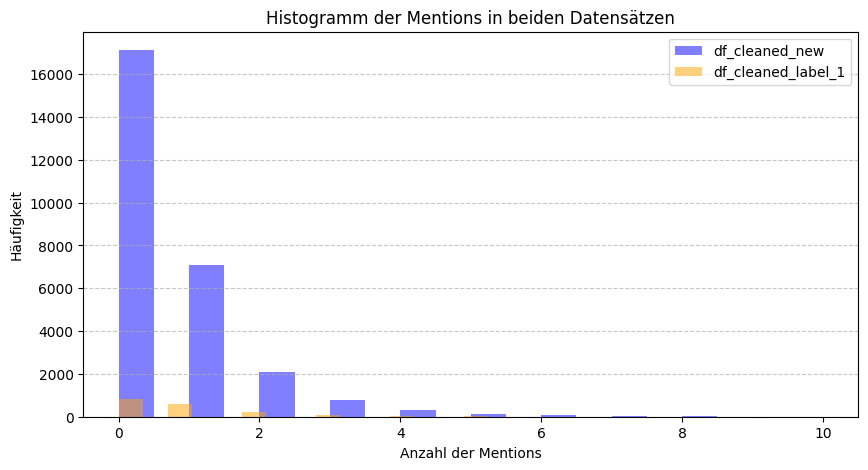

In [18]:

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_label_1['num_mentions'] = df_cleaned_label_1['tweet'].apply(lambda x: x.count('@'))


plt.figure(figsize=(10, 5))

# Histogramm für df_cleaned_new
plt.hist(df_cleaned_new['num_mentions'], bins=20, alpha=0.5, label='df_cleaned_new', color='blue')

# Histogramm für df_cleaned_label_1
plt.hist(df_cleaned_label_1['num_mentions'], bins=20, alpha=0.5, label='df_cleaned_label_1', color='orange')

plt.xlabel("Anzahl der Mentions")
plt.ylabel("Häufigkeit")
plt.title("Histogramm der Mentions in beiden Datensätzen")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [26]:
df_cleaned

,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father selfish drag kid run,1,['#run'],NaN
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank lyft credit use cause offer van,2,"['#lyft', '#disapointed', '#getthanked']",NaN
2,3,0,bihday your majesty,bihday majesty,0,[],NaN
3,4,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,model take time mobile phone kissing sunglass mouth tongue sweat droplet sweat droplet sweat droplet,0,['#model'],":mobile_phone:,:kissing_face_with_smiling_eyes:,:smiling_face_with_sunglasses:,:mouth:,:tongue:,:sweat_droplets:,:sweat_droplets:,:sweat_droplets:"
4,5,0,factsguide: society now #motivation,factsguide society motivation,0,['#motivation'],NaN
...,...,...,...,...,...,...,...
27606,31956,0,less than 2 weeks 😅🙏🏼🍹😎🎵 @user #ibiza#bringiton#mallorca#holidays#summer,less week grinning sweat fold hand medium light skin tone tropical drink sunglass musical note,1,"['#ibiza', '#bringiton', '#mallorca', '#holidays', '#summer']",":grinning_face_with_sweat:,:folded_hands:,:medium-light_skin_tone:,:tropical_drink:,:smiling_face_with_sunglasses:,:musical_note:"
27607,31957,0,off fishing tomorrow @user carnt wait first time in 2 years,fishing tomorrow wait first time year,1,[],NaN
27608,31958,0,ate @user isz that youuu?😍😍😍😍😍😍😍😍😍❤️,eat youuu red,1,[],":smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:smiling_face_with_heart-eyes:,:red_heart:"
27609,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,see turner try wrap genuine hero like shame imwithher,0,"['#shame', '#imwithher']",NaN


In [31]:

df_cleaned_emojis = df_cleaned[df_cleaned['emojis'].notna()]
df_cleaned_emojis_label_1 = df_cleaned_label_1[df_cleaned_label_1['emojis'].notna()]

anzahl_datensätze_gesamt = df_cleaned['id'].count()
anzahl_datensätze_mit_emojis = df_cleaned_emojis['id'].count()

anzahl_datensätze_label1 = df_cleaned_label_1['id'].count()
anzahl_datensätze_mit_emojis_label1 = df_cleaned_emojis_label_1['id'].count()

print("Datensätze gesamt/mit emoji")
print(anzahl_datensätze_gesamt)
print(anzahl_datensätze_mit_emojis)

print("Datensätze label1/mit emoji")
print(anzahl_datensätze_label1)
print(anzahl_datensätze_mit_emojis_label1)



Datensätze gesamt/mit emoji
27611
5906
Datensätze label1/mit emoji
1805
92


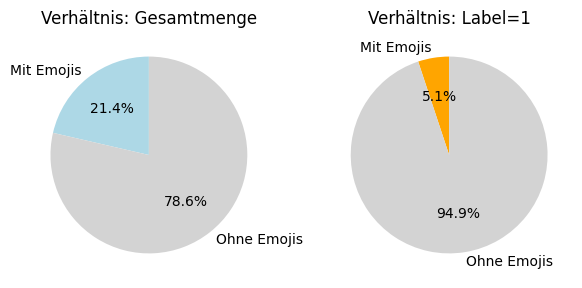

In [29]:
# Daten für die Kreisdiagramme
# 1. Kreisdiagramm: Verhältnis für alle Datensätze
data_gesamt = [anzahl_datensätze_mit_emojis, anzahl_datensätze_gesamt - anzahl_datensätze_mit_emojis]
labels_gesamt = ['Mit Emojis', 'Ohne Emojis']

# 2. Kreisdiagramm: Verhältnis für Datensätze mit label=1
data_label1 = [anzahl_datensätze_mit_emojis_label1, anzahl_datensätze_label1 - anzahl_datensätze_mit_emojis_label1]
labels_label1 = ['Mit Emojis', 'Ohne Emojis']

# Erstellung der Subplots für zwei Kreisdiagramme
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Kreisdiagramm 1: Alle Datensätze
axes[0].pie(data_gesamt, labels=labels_gesamt, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgrey'])
axes[0].set_title('Verhältnis: Gesamtmenge')

# Kreisdiagramm 2: Datensätze mit label=1
axes[1].pie(data_label1, labels=labels_label1, autopct='%1.1f%%', startangle=90, colors=['orange', 'lightgrey'])
axes[1].set_title('Verhältnis: Label=1')

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()

C:\Users\Nasiba\AppData\Local\Temp\ipykernel_10712\3563842010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_10712\3563842010.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')


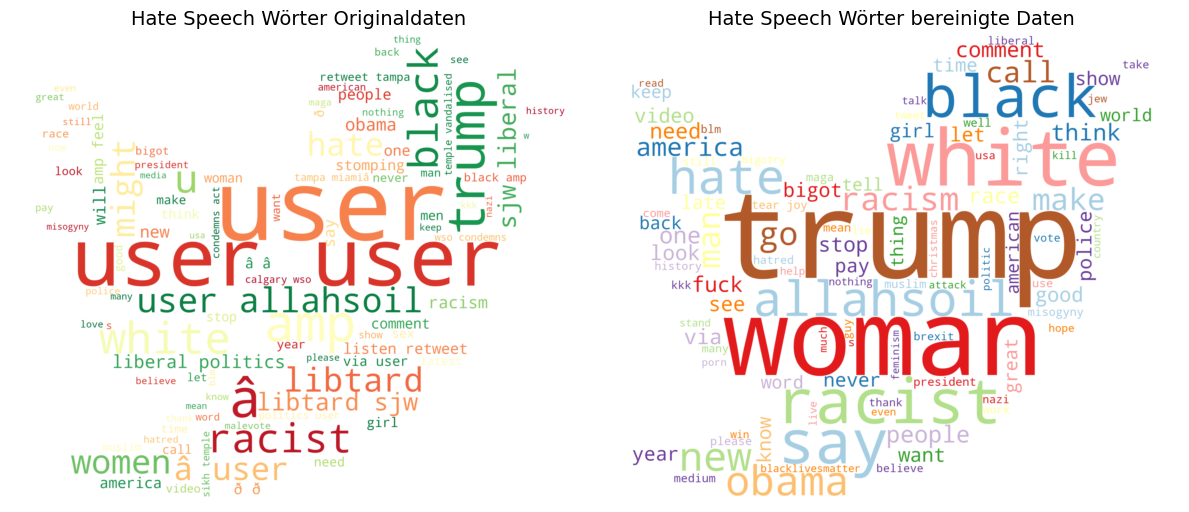

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# WordCloud-Maske laden
wordcloud_mask = np.array(Image.open("twitter.png"))

# Filterung der Daten
df_origin_label_1 = df_origin[df_origin['label'] == 1]
df_cleaned_label_1 = df_cleaned[df_cleaned['label'] == 1]

# Verarbeitung der Texte
df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')
df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_origin_label_1["tweet"].tolist())
dataset_2_text = " ".join(df_cleaned_label_1["tweet_cleaned"].tolist())

# Erstellung der WordClouds
plt.figure(figsize=(12, 6))

# Subplot 1: Originaldaten
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn', background_color='white')
wordcloud.generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter Originaldaten", fontsize=14)

# Subplot 2: Bereinigte Daten
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired', background_color='white')
wordcloud.generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter bereinigte Daten", fontsize=14)

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()
